# Quantized MobileNetV2 for Pneumonia Detection with Google Coral Edge TPU and Transfer Learning.

Use TensorFlow 2 to create an image classification model, train it with the NIH Xray dataset, and convert it to TensorFlow Lite using post-training quantization. Afterwards, compile it for compatibility with the Edge TPU (available in Coral devices).

The model is based on a pre-trained version of MobileNet V2. Training starts start by retraining only the classification layers, reusing MobileNet's pre-trained feature extractor layers. Afterwards, model is fine-tuned by updating weights in some of the feature extractor layers. This approach is a form of Transfer Learning, which is far faster than conventional Machine Learning and performs better on low-end devices.

Once model is trained, use post-training quantization to convert all parameters to int8 format, reducing the model size and increasing inferencing speed. This format is also required for compatibility on the Edge TPU.

## Import the required libraries
In order to quantize both the input and output tensors, we need `TFLiteConverter` APIs that are available in TensorFlow r2.3 or higher. Scikit-learn is needed for splitting the dataset into training and testing batches. Matplotlib and Pandas are used to import, analyze, and plot the dataset.

To install dependencies locally, run the following command

```
python3 -m pip install --user tensorflow numpy pandas matplotlib scikit-learn seaborn
```

Conda users are recommended to run
```
conda config --add channels conda-forge
conda config --set channel_priority strict
conda create -n tf_EdgeTPU python=3.9 jupyterlab tensorflow numpy pandas matplotlib scikit-learn seaborn
conda active tf_EdgeTPU && jupyter lab
```

And for MacOS users, install miniforge then run
```
conda create -n tf_EdgeTPU python=3.9 jupyterlab numpy pandas matplotlib scikit-learn seaborn
conda active tf_EdgeTPU
conda install -c apple tensorflow-deps
python -m pip install tensorflow-macos tensorflow-metal
jupyter lab
```

Run the following cell to load the necessary packages. Make sure to change the Accelerator on the right to `TPU` if you're running on Google Colab.

In [1]:
# general imports
import os
from datetime import datetime

# linalg and data/plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ML
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)
strategy = tf.distribute.get_strategy()

2.8.0


## Preliminary Analysis of Pneumonia Deaths
Why are we targeting Pneumonia? While we have hopefully passed the height COVID-19 pandemic, those who where affected may face complications such as COVID-onset Pneumonia.

“As we have learned more about SARS-CoV-2 and resulting COVID-19, we have discovered that in severe COVID-19, a significant pro-inflammatory condition can result in several critical diseases, complications and syndromes,” -  Panagis Galiatsatos, M.D., M.H.S., expert on lung disease at Johns Hopkins Bayview Medical Center 

COVID-19 can cause lung complications such as pneumonia, causing lasting harm to the lungs and other organs. In pneumonia, the lungs become filled with fluid and inflamed, leading to breathing difficulties. For some people, breathing problems can become severe enough to require treatment at the hospital with oxygen or even a ventilator. The pneumonia that COVID-19 causes tends to take hold in both lungs. Air sacs in the lungs fill with fluid, limiting their ability to take in oxygen and causing shortness of breath, cough and other symptoms. While most people recover from pneumonia without any lasting lung damage, the pneumonia associated with COVID-19 can be severe. Even after the disease has passed, lung injury may result in breathing difficulties that might take months to improve.

As we can see below, from 2019-2022 there was a significant increase in Pneumonia deaths, with spikes in late 2019, throughout 2020, and late 2021. 

### Read the dataset 
Data was obtained from https://www.cdc.gov/nchs/pressroom/sosmap/flu_pneumonia_mortality/flu_pneumonia.htm. We import and take a quick look using pandas. We're only concerned with the pneumonia data, so we remove Area, Influenza, and COVID-19 related data. Afterwards, we create two sets of graphs, one with the years 2019-2022 and one without, to demonstrate the recent increase in cases. 

In [3]:
pnd = pd.read_csv("data/pneumonia_deaths.csv")
pnd = pnd.drop(pnd.columns[[0, 1, 7, 9, 12, 13, 14]], axis=1)
pnd.replace(",", "", regex=True, inplace=True)
pnd["NUM PNEUMONIA DEATHS"] = pd.to_numeric(
    pnd["NUM PNEUMONIA DEATHS"], errors="coerce"
)
pnd.info()
pnd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AGE GROUP             438 non-null    object 
 1   SEASON                438 non-null    object 
 2   WEEK                  438 non-null    int64  
 3   THRESHOLD             438 non-null    float64
 4   BASELINE              438 non-null    float64
 5   PERCENT PIC           438 non-null    float64
 6   NUM PNEUMONIA DEATHS  438 non-null    int64  
 7   NUM COVID-19 DEATHS   438 non-null    object 
dtypes: float64(3), int64(2), object(3)
memory usage: 27.5+ KB


,AGE GROUP,SEASON,WEEK,THRESHOLD,BASELINE,PERCENT PIC,NUM PNEUMONIA DEATHS,NUM COVID-19 DEATHS
0,All,2021-22,40,5.7,5.4,20.5,9626,11047
1,All,2021-22,41,5.8,5.5,19.0,8719,9731
2,All,2021-22,42,5.9,5.6,17.8,8154,8847
3,All,2021-22,43,6.0,5.7,16.6,7678,7876
4,All,2021-22,44,6.1,5.8,15.6,7136,7143


### Plot using Matplotlib & Seaborn
Lets compare Pneumonia deaths before and after the pandemic. We also want to use a retina resolution for our plots

In [4]:
sns.set(rc={"figure.dpi": 100, 'savefig.dpi': 300})
sns.set_context('notebook')
sns.set_style("ticks")

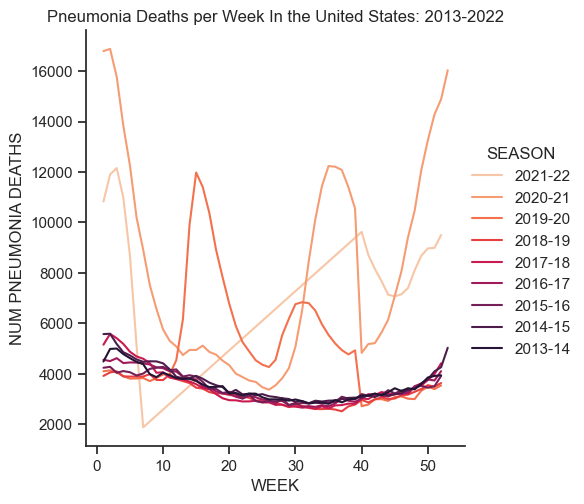

In [5]:
sns.relplot(
    data=pnd,
    x="WEEK",
    y="NUM PNEUMONIA DEATHS",
    hue="SEASON",
    kind="line",
    palette="rocket_r",
    height=5,
    facet_kws=dict(sharex=False)
).set(title="Pneumonia Deaths per Week In the United States: 2013-2022")
plt.savefig("output/seaborn/REL_Pneumonia_Deaths_per_Week_In_the_United_States_1322.png")

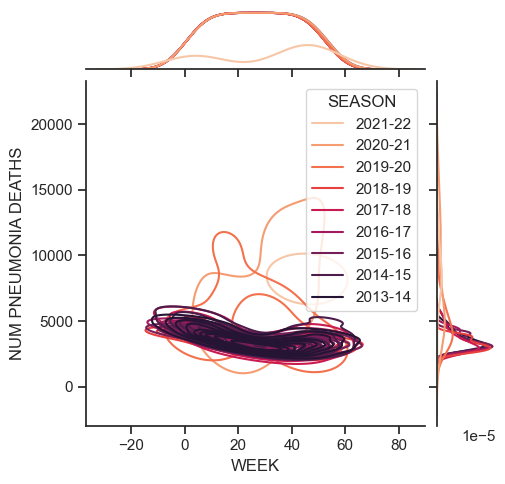

In [6]:
sns.jointplot(
    data=pnd,
    x="WEEK",
    y="NUM PNEUMONIA DEATHS",
    hue="SEASON",
    kind="kde",
    palette="rocket_r",
    height=5
)
plt.savefig("output/seaborn/JOINT_Pneumonia_Deaths_per_Week_In_the_United_States_1322.png")

In [7]:
pnd.drop(pnd.index[pnd["SEASON"] == "2021-22"], inplace=True)
pnd.drop(pnd.index[pnd["SEASON"] == "2020-21"], inplace=True)
pnd.drop(pnd.index[pnd["SEASON"] == "2019-20"], inplace=True)

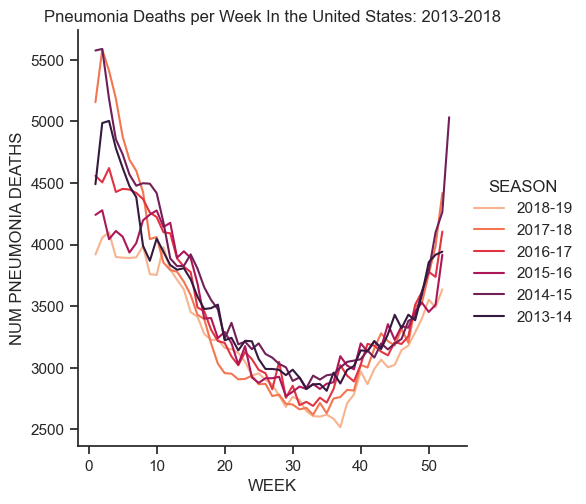

In [8]:
sns.relplot(
    data=pnd,
    x="WEEK",
    y="NUM PNEUMONIA DEATHS",
    hue="SEASON",
    kind="line",
    palette="rocket_r",
    height=5,
    facet_kws=dict(sharex=False)
).set(title="Pneumonia Deaths per Week In the United States: 2013-2018")
plt.savefig("output/seaborn/REL_Pneumonia_Deaths_per_Week_In_the_United_States_1318.png")

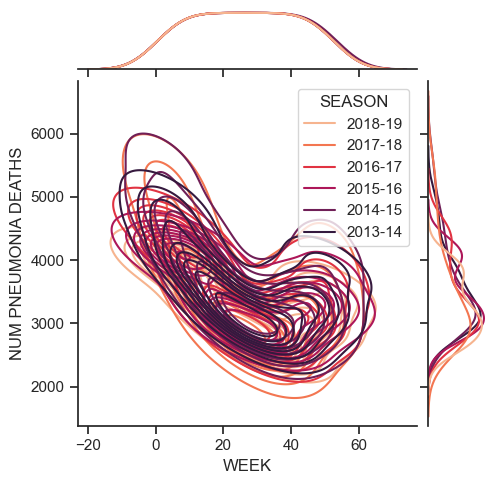

In [9]:
sns.jointplot(
    data=pnd,
    x="WEEK",
    y="NUM PNEUMONIA DEATHS",
    hue="SEASON",
    kind="kde",
    palette="rocket_r",
    height=5
)
plt.savefig("output/seaborn/JOINT_Pneumonia_Deaths_per_Week_In_the_United_States_1318.png")

## Prepare the Training Data
The Chest X-ray data we are using from Cell divides the data into train, val, and test files. There are only 16 files in the validation folder, and we would prefer to have a less extreme division between the training and the validation set. We will append the all the files and create a new split that resembles the standard 80:20 division instead.

In [10]:
filenames = tf.io.gfile.glob("data/chest_xray/train/*/*")
filenames.extend(tf.io.gfile.glob("data/chest_xray/val/*/*"))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

### Set some constants
- BATCH_SIZE: Size of each batch. Further multiplied by optimizer. Set this to the largest size that fits into your gpu mem. 
- IMG_SIZE: size of each image (max 600px, needs to be a square of 2). Set to 224 as its a good balance between speed, memory usage, and accuracy. 
- EPOCHS: Number of epochs to run. 2/3's of epoch's are used for initial training, and 1/3 are used for fine-tuning. I recommend setting this to a multiple of 15.

In [11]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = 224
EPOCHS = 15
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']

### Helper Functions
Currently our dataset is just a list of filenames. We want to map each filename to the corresponding `(image, label)` pair. The following methods will help us do that. As we only have two labels, we will rewrite the label so that `1` or `True` indicates pneumonia and `0` or `False` indicates normal. The images originally have values that range from `[0, 255]`. CNNs work better with smaller numbers so we will scale this down.

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])


def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### Caching
Here we have a function to use buffered prefetching so we can yield data from disk without having I/O blocking while training the dataset. This especially helps with the TPU, although it increase time for the first epoch a fair bit.

Use buffered prefetching so we can yield data from disk without having I/O blocking

In [13]:
def prepare_for_training(ds):
    ds = ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=TRAIN_IMG_COUNT)
    ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

### Correct for Data Imbalence
There are way more images that are classified as pneumonia than normal. This shows that we have a imbalance in our data. The weight for class `0` (Normal) is a lot higher than the weight for class `1` (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data, to optimize our CNN network and provide us with more accurate metrics.

In [14]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(tf.data.Dataset.from_tensor_slices(train_filenames)).numpy()

weight_for_0 = (1 / COUNT_NORMAL) * TRAIN_IMG_COUNT / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * TRAIN_IMG_COUNT / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.68


### Load and Visualize Dataset
Now we can load the dataset. We use the `ts.data` api once again to prevent blocking and keep the GPU active. While we're at it, lets visualize some images.

In [15]:
test_ds = (
    tf.data.Dataset.list_files("data/chest_xray/test/*/*")
        .map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .batch(BATCH_SIZE)
)

train_ds = prepare_for_training(tf.data.Dataset.from_tensor_slices(train_filenames))
val_ds = prepare_for_training(tf.data.Dataset.from_tensor_slices(val_filenames))

2022-03-06 23:30:52.784558: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


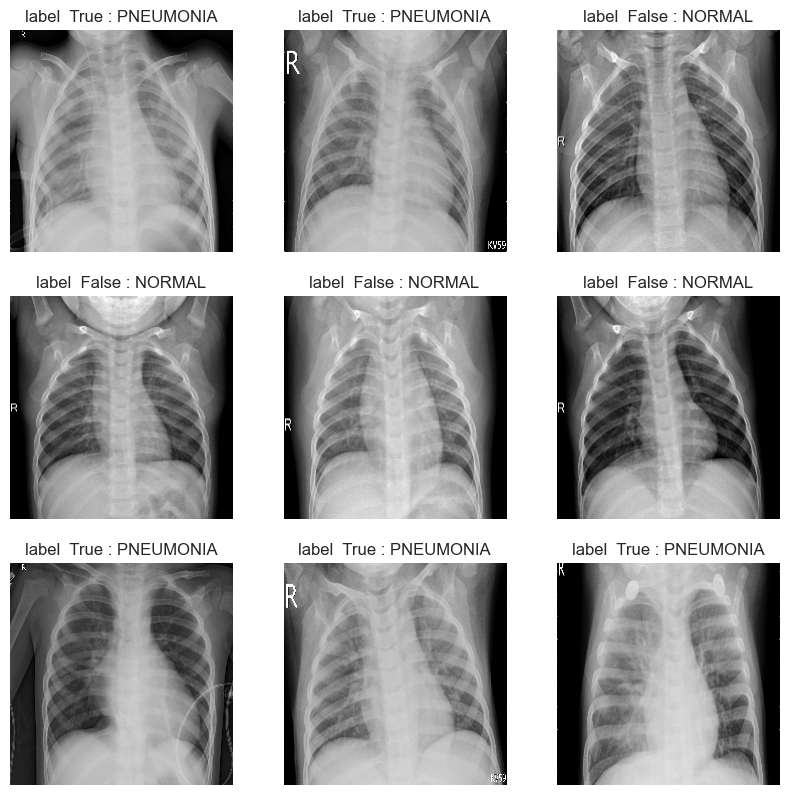

In [16]:
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title("label  {n} : {s}".format(n=labels[i].numpy(), s=CLASS_NAMES[labels[i]]))
    plt.axis("off")
    plt.savefig("output/seaborn/visualization.png")

## Train the model 
Our goal is to create a model that's capable of transfer learning on just the last fully-connected layer. 

We start with MobileNet V2 from Keras as the base model, which is pre-trained with the ImageNet dataset (trained to recognize 1,000 classes), providing us a great feature extractor for image classification. We then train a new classification layer with our pneumonia dataset. 

Why did we pick the MobileNet V2 model? Of all the pretrained models available on `tf.keras.applications` (MobileNet, DenseNet, Inception, Xception, NASNet, ResNet, and VGG) only 3 don't fill up the Edge TPU memory (MobileNet, Xception,and NASNet). Of those three MobileNet is the quickest to train, fastest to run, and 100% of its operations run on the Edge TPU. For comparison, only 11 of Xception's 128 operations, and only 1 of NASNetMobile's 991 operations run on the Edge TPU.

When instantiating the `MobileNetV2` model, we specify the `include_top=False` argument in order to load the network *without* the classification layers at the top. Then we set `trainable` false to freeze all the weights in the base model. This effectively converts the model into a feature extractor because all the pre-trained weights and biases are preserved in the lower layers when we begin training for our classification head.

We then create a new sequential model and pass the frozen MobileNet model as the base of the graph, and append new classification layers so we can set the final output dimension to match the number of classes in our dataset.

Afterwards, `compile()` the model (this is really just a configuration step). 

Since there are only two possible labels for the image, we will be using the` binary_crossentropy` loss. When we fit the model, identify the class weights. Because we are using a TPU and a small model combined with transfer learning, training will be relatively quick.

In [17]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(
        weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False
    )
    base_model.trainable = False
    model = tf.keras.Sequential(
        [
            base_model,
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalseNegatives(name='fn')
        ]
    )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,626,689
Trainable params: 368,705
Non-tr

### Tensorboard
TensorBoard provides the visualization and tooling needed for machine learning experimentation. It graphs and analyzes metrics, as well as optionally profiles our models. Lets setup the tensorboard callback, and pass that to the model. 

In [18]:
%load_ext tensorboard
!rm -rf ./output/tensorboard
logdir = "output/tensorboard/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

### Initial Fitting
Load our training dataset, set the weight to compensate for our imbalance of data, and add a `tensorboard_callback` so we can continously update tensorboard with our results.

In [19]:
history = model.fit(
    train_ds,
    epochs=int(EPOCHS / 3 * 2),
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[tensorboard_callback]
)

Epoch 1/10
262/262 [==============================] - 42s 151ms/step - loss: 0.1688 - accuracy: 0.9314 - precision: 0.9799 - recall: 0.9264 - auc: 0.9823 - tp: 2870.0000 - fp: 59.0000 - tn: 1028.0000 - fn: 228.0000 - val_loss: 0.0804 - val_accuracy: 0.9675 - val_precision: 0.9796 - val_recall: 0.9771 - val_auc: 0.9947 - val_tp: 767.0000 - val_fp: 16.0000 - val_tn: 246.0000 - val_fn: 18.0000
Epoch 2/10
262/262 [==============================] - 37s 140ms/step - loss: 0.0801 - accuracy: 0.9725 - precision: 0.9931 - recall: 0.9697 - auc: 0.9950 - tp: 3004.0000 - fp: 21.0000 - tn: 1066.0000 - fn: 94.0000 - val_loss: 0.0826 - val_accuracy: 0.9704 - val_precision: 0.9760 - val_recall: 0.9847 - val_auc: 0.9950 - val_tp: 773.0000 - val_fp: 19.0000 - val_tn: 243.0000 - val_fn: 12.0000
Epoch 3/10
262/262 [==============================] - 34s 129ms/step - loss: 0.0616 - accuracy: 0.9761 - precision: 0.9947 - recall: 0.9729 - auc: 0.9967 - tp: 3014.0000 - fp: 16.0000 - tn: 1071.0000 - fn: 84.0000

### Finetune the model
Finetuning is an art when it comes to Machine Learning, and there are many ways to adjust the model in efforts to improve it. We unlock the last 100 layers of our `MobileNetV2` model, and reduce the learning rate a bit. We also need to recompile the model in order to save our changes.


In [20]:
with strategy.scope():
    base_model.trainable = True
    fine_tune_at = 100
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalseNegatives(name='fn')
        ]
    )

In [21]:
history_fine = model.fit(
    train_ds,
    epochs=EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[tensorboard_callback]
)

Epoch 10/15
262/262 [==============================] - 57s 208ms/step - loss: 1.2507 - accuracy: 0.9008 - precision: 0.9266 - recall: 0.9406 - auc: 0.9060 - tp: 2914.0000 - fp: 231.0000 - tn: 856.0000 - fn: 184.0000 - val_loss: 0.0961 - val_accuracy: 0.9761 - val_precision: 0.9897 - val_recall: 0.9783 - val_auc: 0.9932 - val_tp: 768.0000 - val_fp: 8.0000 - val_tn: 254.0000 - val_fn: 17.0000
Epoch 11/15
262/262 [==============================] - 56s 213ms/step - loss: 0.1886 - accuracy: 0.9484 - precision: 0.9797 - recall: 0.9500 - auc: 0.9819 - tp: 2943.0000 - fp: 61.0000 - tn: 1026.0000 - fn: 155.0000 - val_loss: 0.1045 - val_accuracy: 0.9713 - val_precision: 0.9846 - val_recall: 0.9771 - val_auc: 0.9912 - val_tp: 767.0000 - val_fp: 12.0000 - val_tn: 250.0000 - val_fn: 18.0000
Epoch 12/15
262/262 [==============================] - 52s 197ms/step - loss: 0.0966 - accuracy: 0.9656 - precision: 0.9900 - recall: 0.9632 - auc: 0.9931 - tp: 2984.0000 - fp: 30.0000 - tn: 1057.0000 - fn: 114.

### Results: 
A model isn't any good if we can't test it. First we open up our tensorboard logs to take a look at performance, histograms, and scaler data. After that we evaluate the model on the test dataset, for accuracy and the area under the. Finally we plot a set of confusion matrices (Normalized & Not Normalized) as well as run a prediction for a given image. 

In [22]:
%tensorboard --logdir output/tensorboard/

Launching TensorBoard...

In [23]:
loss, accuracy, precision, recall, auc, tp, fp, tn, fn = model.evaluate(test_ds, verbose=0)
print('Tested model precision: {:5.2f}%'.format(100 * precision))
print('Tested model accuracy: {:5.2f}%'.format(100 * accuracy))
print('Tested model recall: {:5.2f}%'.format(100 * recall))
print('Tested model AUC: {:5.2f}%'.format(100 * auc))

Tested model precision: 80.58%
Tested model accuracy: 84.46%
Tested model recall: 98.97%
Tested model AUC: 89.92%


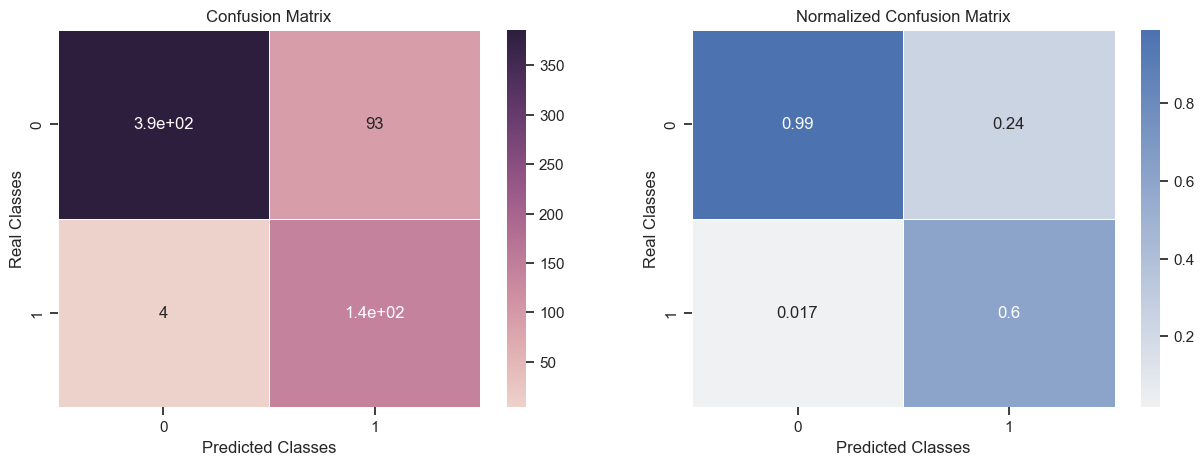

In [24]:
cfn_matrix = [[tp, fp], [fn, tn]]

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(cfn_matrix, cmap=sns.cubehelix_palette(as_cmap=True), linewidths=0.5, annot=True, ax=ax)
plt.title('Confusion Matrix')
plt.ylabel('Real Classes')
plt.xlabel('Predicted Classes')
plt.savefig('output/seaborn/confusion_matrix.png')

test_filenames = tf.io.gfile.glob("data/chest_xray/test/*/*")
COUNT_NORMAL = len([filename for filename in test_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in test_filenames if "PNEUMONIA" in filename])
cfn_norm_matrix = np.array([[1.0 / COUNT_PNEUMONIA, 1.0 / COUNT_PNEUMONIA], [1.0 / COUNT_NORMAL, 1.0 / COUNT_NORMAL]])
norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

ax = fig.add_subplot(1, 2, 2)
sns.heatmap(norm_cfn_matrix, cmap=sns.color_palette("light:b", as_cmap=True), linewidths=0.5, annot=True, ax=ax)
plt.title('Normalized Confusion Matrix')
plt.ylabel('Real Classes')
plt.xlabel('Predicted Classes')
plt.savefig('output/seaborn/normalized_confusion_matrix.png')

## Compiling for the Edge TPU 
The Google Edge TPU is an emerging hardware accelerator that is cost, power and speed efficient, and is available for prototyping and production purposes. The Edge TPU is not only capable of tackling common computer vision tasks, but also surpasses other hardware accelerators, especially when the entire model can be deployed to the Edge TPU. Co-embedding the Edge TPU in cameras allows a seamless analysis of primary data. In summary, the Edge TPU is a maturing system that has proven its usability across multiple tasks.

As stated earlier in the notebook, you need to quantize and optimize your model before deploying it to the Edge TPU. The quantized models use lower-precision (e.g. 8-bit instead of 32-bit float), leading to benefits during deployment, such as model compression, latency reduction, and compatibility with machine learning accelerators. Non-quantized models will run entirely on the CPU. As stated earlier in the notebook, the MobleNetV2 model has full compatiblity with the Edge TPU, as it can fit the compressed into its cache as well as run all its layers on the TPU accelerator. 

### Compile the Model for TFLite
There are several post-training quantization options to choose from, but we want to use full integer quantization, which provides a 4x reduction in size, and over a 3x speedup, and is the only model compatible with the Edge TPU and Microcontrollers. 

For full integer quantization, you need to calibrate or estimate the range, i.e, `(min, max)` of all floating-point tensors in the model. Unlike constant tensors such as weights and biases, variable tensors such as model input, activations (outputs of intermediate layers) and model output cannot be calibrated unless we run a few inference cycles. As a result, the converter requires a representative dataset to calibrate them. This dataset can be a small subset (around ~100-500 samples) of the training or validation data. We grab, decode, and resize 100 images using the `representative_dataset()` function below.

In [25]:
def representative_data_gen():
    dataset_list = tf.data.Dataset.list_files("data/chest_xray/test/*/*")
    for i in range(100):
        path = next(iter(dataset_list))
        file_bytes = tf.io.read_file(path)
        img = tf.io.decode_jpeg(file_bytes, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = tf.expand_dims(img, 0)
        yield [img]

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

with open("output/keras/xray_mobilenetv2_quant_model.tflite", "wb") as f:
    f.write(tflite_model_quant)

with open('output/keras/xray_labels.txt', 'w') as f:
    f.writelines("%s\n" % name for name in CLASS_NAMES)

2022-03-06 23:42:47.547360: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmprs2rldpp/assets


INFO:tensorflow:Assets written to: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmprs2rldpp/assets
/Users/shauryasingh/miniforge3/envs/tf_EdgeTPU/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-03-06 23:43:53.066271: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-06 23:43:53.066284: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-06 23:43:53.066711: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmprs2rldpp
2022-03-06 23:43:53.087016: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-06 23:43:53.087031: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedMode

Now that we compiled it, lets quickly check out inputs and ouputs are indeed `uint8`

In [27]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]["dtype"]
output_type = interpreter.get_output_details()[0]["dtype"]
print("input: ", input_type)
print("output: ", output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


### Compiling for Edge TPU
Google's edgeTPU compiler only works on linux, and only on x86_64 at that. Lets spin up a docker container to get that working run `docker build --platform linux/amd64 --tag edgetpu_compiler https://github.com/tomassams/docker-edgetpu-compiler.git` if you haven't already, as it builds the container. Obvioiusly make sure you have Docker installed as well. 

The following cell will compile and write our model to `xray_mobilenetv2_quant_model_edgetpu.tflite`

In [28]:
!docker run -it --platform linux/amd64 --rm -v (pwd):/home/edgetpu edgetpu_compiler edgetpu_compiler output/keras/xray_mobilenetv2_quant_model.tflite
!mv xray_mobilenetv2_quant_model_edgetpu.tflite output/keras/xray_mobilenetv2_quant_model_edgetpu.tflite
!cat xray_mobilenetv2_quant_model_edgetpu.log && rm xray_mobilenetv2_quant_model_edgetpu.log

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 7657 ms.

Input model: output/keras/xray_mobilenetv2_quant_model.tflite
Input size: 2.94MiB
Output model: xray_mobilenetv2_quant_model_edgetpu.tflite
Output size: 3.11MiB
On-chip memory used for caching model parameters: 3.33MiB
On-chip memory remaining for caching model parameters: 4.36MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: xray_mobilenetv2_quant_model_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 
Edge TPU Compiler version 16.0.384591198
Input: output/keras/xray_mobilenetv2_quant_model.tflite
Output: xray_mobilenetv2_quant_model_edgetpu.tflite

Operator                       Count      Status

QUANTIZE                       2          Mapped to 

## Running Testing
Run locally with USB accelerator or on a dev board: 
```sh
python3 classify_image.py \
  --model <model>.tflite  \
  --labels <labels>.txt \
  --input <image>.jpeg
```

For example:
```sh
python3 classify_image.py \
  --model output/keras/xray_mobilenetv2_quant_model_edgetpu.tflite  \
  --labels output/keras/xray_labels.txt \
  --input data/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
```

Heres my results: 
```sh
----INFERENCE TIME----
Note: The first inference on Edge TPU is slow because it includes loading the model into Edge TPU memory.
115.7ms
14.6ms
14.6ms
14.5ms
14.4ms
-------RESULTS--------
PNEUMONIA: 7.16323
```